**Подключение библиотек и настройка pandas**

In [50]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Скачивание и предобработка тренировочных данных**

In [ ]:
df = pd.read_csv('data/train.csv')

le = LabelEncoder()

for i in df.columns:
    if df[i].dtypes == 'object':
        df[i] = le.fit_transform(df[i])

for i in df.columns:
    if df[df[i].isnull()]['Id'].count() != 0:
        df[i] = df[i].fillna(df[i].mode().iloc[0])

X = df[df.columns.difference(['SalePrice'])]
y = df['SalePrice']

**Скачивание и предобработка тестровых данных**

In [84]:
df_test = pd.read_csv('data/test.csv')

le = LabelEncoder()

for i in df_test.columns:
    if df_test[i].dtypes == 'object':
        df_test[i] = le.fit_transform(df_test[i])

for i in df_test.columns:
    if df_test[df_test[i].isnull()]['Id'].count() != 0:
        df_test[i] = df_test[i].fillna(df_test[i].mode().iloc[0])

df_test = df_test[X.columns]

**Проведение факторного анализа с использованием statsmodels**

In [9]:
from statsmodels.multivariate.factor import Factor

fa = Factor(X, n_factor=3, method='ml')
res = fa.fit(X)

res.get_loadings_frame(threshold=0.3)

c:\mArt\dataScience\Kaggle\Housing_Prices_Competition_Kaggle\.venv\lib\site-packages\statsmodels\multivariate\factor.py:417: UserWarning: Fitting did not converge
  warnings.warn("Fitting did not converge")


,factor 0,factor 1,factor 2
YearBuilt,-0.969275,-0.117044,0.010336
GarageYrBlt,-0.880331,-0.043182,-0.121429
Foundation,-0.774616,-0.092133,-0.172882
YearRemodAdd,-0.770013,-0.161703,-0.148744
GarageFinish,0.651664,0.288573,-0.013674
BsmtQual,0.563095,0.352167,-0.061797
GarageCars,-0.535188,-0.436339,0.032414
HeatingQC,0.532000,0.151419,0.143699
GarageType,0.529562,0.245209,-0.228099
ExterQual,0.522358,0.405233,-0.013700


In [59]:
factor_df = res.get_loadings_frame().data
factor_1 = factor_df.loc['YearBuilt':'MSZoning']
factor_2 = factor_df.loc['GrLivArea':'OpenPorchSF']
factor_3 = factor_df.loc['2ndFlrSF':'MSSubClass']

X_1 = X[list(factor_1.index)]
X_2 = X[list(factor_2.index)]
X_3 = X[list(factor_3.index)]

**Кросс-валидация**

In [66]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y, test_size=0.2, random_state=42)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y, test_size=0.2, random_state=42)
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3, y, test_size=0.2, random_state=42)

*Регрессионное дерево*

In [68]:
rfr = RandomForestRegressor(max_depth=2, random_state=0)

rfr.fit(X_train_1, y_train_1)
y_test_1 = rfr.predict(X_val_1)

rfr.fit(X_train_2, y_train_2)
y_test_2 = rfr.predict(X_val_2)

rfr.fit(X_train_3, y_train_3)
y_test_3 = rfr.predict(X_val_3)

*Подсчет RMSE*

In [70]:
print('На первой группе: ', root_mean_squared_error(y_test_1, y_val_1))
print('На второй группе: ', root_mean_squared_error(y_test_2, y_val_2))
print('На третьей группе: ', root_mean_squared_error(y_test_3, y_val_3))

На первой группе:  54018.81234112644
На второй группе:  47806.6582707989
На третьей группе:  65740.57462577584


*Ridge-regression*

In [72]:
from sklearn.linear_model import Ridge

ridge = Ridge(1.0)

ridge.fit(X_train_1, y_train_1)
y_test_1 = ridge.predict(X_val_1)

ridge.fit(X_train_2, y_train_2)
y_test_2 = ridge.predict(X_val_2)

ridge.fit(X_train_3, y_train_3)
y_test_3 = ridge.predict(X_val_3)

In [73]:
print('На первой группе: ', root_mean_squared_error(y_test_1, y_val_1))
print('На второй группе: ', root_mean_squared_error(y_test_2, y_val_2))
print('На третьей группе: ', root_mean_squared_error(y_test_3, y_val_3))

На первой группе:  53668.18922017857
На второй группе:  37046.85211504076
На третьей группе:  68043.00884722464


*Lasso-regression*

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)


lasso.fit(X_train, y_train)
y_test = lasso.predict(X_val)

print(root_mean_squared_error(y_test, y_val))

34573.04376809833


c:\mArt\dataScience\Kaggle\Housing_Prices_Competition_Kaggle\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.917e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


*XGBoost*

In [81]:
from xgboost import XGBRegressor

bst = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1)

bst.fit(X_train, y_train)
y_test = bst.predict(X_val)
print(root_mean_squared_error(y_test, y_val))

41283.43359375


*Gradient Boosting Regression*

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

gbr.fit(X_train, y_train)
y_test = gbr.predict(X_val)
print(root_mean_squared_error(y_test, y_val))

27992.239775902566


*Test*

In [97]:
gbr = GradientBoostingRegressor()

gbr.fit(X, y)
y_test = gbr.predict(df_test)

*Feature selection*

In [99]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

<Axes: xlabel='Feature', ylabel='Columns'>

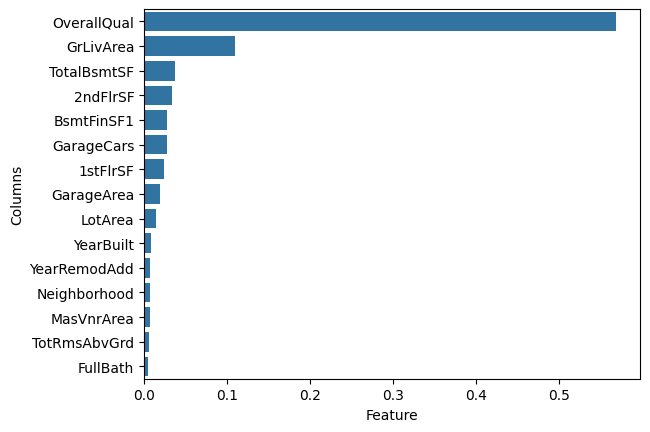

In [108]:
feature_imp_df = pd.DataFrame({'Columns':X.columns, 'Feature': model.feature_importances_}).sort_values(by='Feature', ascending=False).reset_index(drop=True)
sns.barplot(data=feature_imp_df.head(15), x='Feature', y='Columns')

In [98]:
ans = pd.DataFrame({'Id' : range(X.shape[0] + 1, X.shape[0] + 1 + y_test.shape[0]), 'SalePrice' : y_test}).set_index('Id')

ans.to_csv('ans/ans_2.csv')